In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### The Data

In [2]:
life = pd.read_csv('WHO_Life_Expectancy_Data.csv')
life.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


In [3]:
life.shape

(2864, 21)

In [4]:
#Renaming variable for ease of use
life = life.rename(columns={'Infant_deaths': 'InfantDeaths',
                                       'Under_five_deaths': 'UnderFiveDeaths', 
                                       'Adult_mortality': 'AdultMortality', 
                                       'Alcohol_consumption': 'AlcoholConsumption', 
                                       'GDP_per_capita': 'GDP_Per_Capita',
                                       'Population_mln': 'Population',
                                       'Schooling': 'Education',
                                       'Thinness_ten_nineteen_years': 'Thinness_10-19',
                                       'Thinness_five_nine_years': 'Thinness_5-9', 
                                       'Economy_status_Developed': 'Developed', 
                                       'Economy_status_Developing': 'Developing', 
                                       'Life_expectancy': 'LifeExpectancy',})

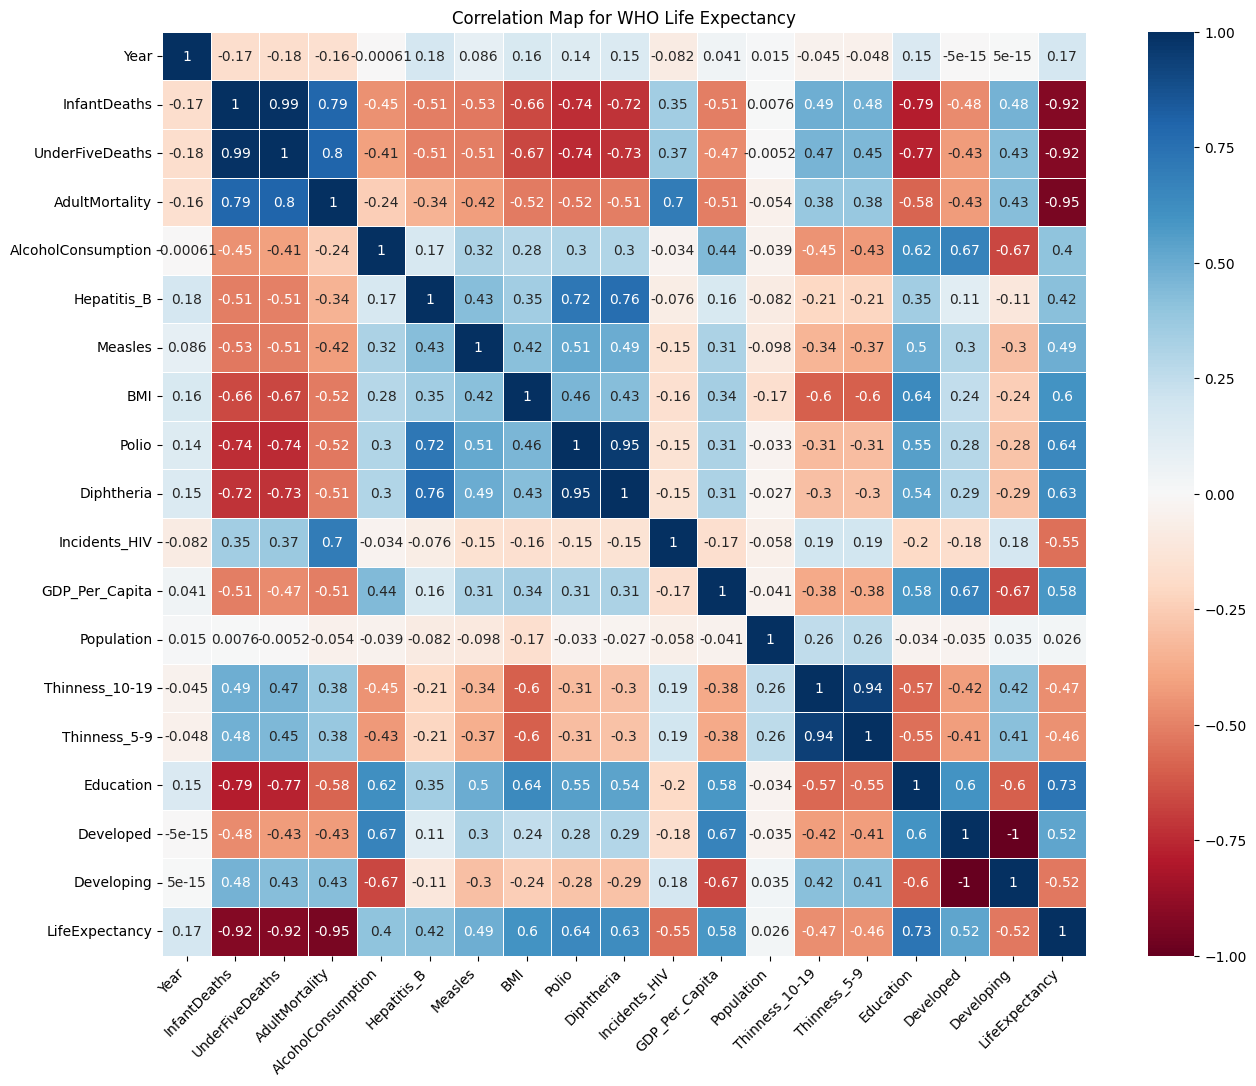

In [5]:
#seperating country and region from the matrix as they are string variables, pearson correlation
corr = life.loc[:, ~life.columns.isin(['Country', 'Region'])].corr(method='pearson')

#correlation matrix
plt.figure(figsize=(16,12))
plt.title('Correlation Map for WHO Life Expectancy')
ax = sns.heatmap(corr, 
                 vmin=-1, vmax=1, center=0,
                 cmap='RdBu',
                 square=True,
                 linewidths=.5,
                 linecolor='white',
                 annot=True)
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45,
                   horizontalalignment='right');

In [6]:
#Choosing to drop columns population, underfive deaths, developing, polio, thinness_5-9
#The are either not correlated much with the target variable or are extremely correlated with another variable in the data
life = life.drop('Population', axis=1)
life = life.drop('UnderFiveDeaths', axis=1)
life = life.drop('Polio', axis=1)
life = life.drop('Thinness_5-9', axis=1)
life = life.drop('Developing', axis=1)

### Train-Test Split

In [7]:
#Create X and y
from sklearn.model_selection import train_test_split
X = life.drop('LifeExpectancy', axis=1)
y = life['LifeExpectancy']

#Splitting the dataset into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#Label encoding on training data to turn country and regions into numbers 
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
X_train['Country'] = LE.fit_transform(X_train['Country'])
X_train['Region'] = LE.fit_transform(X_train['Region'])
X_test['Country'] = LE.fit_transform(X_test['Country'])
X_test['Region'] = LE.fit_transform(X_test['Region'])

#Scale the TRAINING data only, test set will be left as is
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [9]:
#Hyperparamters for linear regression and randomized search cv 
param_lin= {'alpha':np.logspace(-5,2,8),
              'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}

#create classifier
lin_reg = ElasticNet()

#create randomized search with 50 iterations and 5-folds for CV, scoring method is negative mean squared error
search_lin_reg = RandomizedSearchCV(lin_reg, 
                                    param_lin,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    n_jobs=-1,
                                    n_iter=50,
                                    verbose=1,
                                    random_state=101)

#fit the search to see which params are good
result_lin_reg = search_lin_reg.fit(X_train, y_train)

#print the best scores and best params
print(result_lin_reg.best_score_)
print(result_lin_reg.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
-2.009089224045083
{'l1_ratio': 0.99, 'alpha': 0.001}


In [10]:
#Create final model
lin_reg_model = ElasticNet(alpha=0.001, 
                           l1_ratio=0.99)

#cross validate the model with 10 folds 
kfolds_lin_reg = cross_val_score(lin_reg_model,
                         X_train,
                         y_train,
                         cv = 10,
                         scoring='neg_mean_squared_error')

#cross validation scores to test the stablity of the model
print(kfolds_lin_reg)
print("the mean is:", kfolds_lin_reg.mean())
print("the std is:", kfolds_lin_reg.std())

[-2.01419788 -2.11128632 -2.03852034 -2.10503558 -2.07489826 -1.80234578
 -1.94948488 -1.93312416 -2.14185913 -1.89328837]
the mean is: -2.006404069699207
the std is: 0.10387727119782766


In [11]:
#fit the model and time it
start_lin_reg = time.time()
lin_reg_model.fit(X_train, y_train)
stop_lin_reg = time.time()

In [12]:
#predict on the test set
lin_pred = lin_reg_model.predict(X_test)

In [13]:
#metrics for linear regression model
mae_lin = mean_absolute_error(y_test,lin_pred)
mse_lin = mean_squared_error(y_test,lin_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test,lin_pred))
r2_lin = r2_score(y_test, lin_pred)
fit_time_lin = {stop_lin_reg - start_lin_reg}


print('The Mean Absolute Error is:', mae_lin)
print('The Mean Squared Error is:', mse_lin)
print('The Root Mean Squared Error is:', rmse_lin)
print('The R2 value is:', r2_lin)
print('The mean life expectancy of the data is:', np.mean(life['LifeExpectancy']))
print('Linear Regression Training Time:', fit_time_lin)

The Mean Absolute Error is: 1.1310327959201216
The Mean Squared Error is: 1.9815848331475991
The Root Mean Squared Error is: 1.4076877612409646
The R2 value is: 0.9763786357054162
The mean life expectancy of the data is: 68.85607541899441
Linear Regression Training Time: {0.00311279296875}


### K-Nearest Neighbors Regression

In [14]:
from sklearn.neighbors import KNeighborsRegressor

In [15]:
#parameters for KNN randomized search
param_knn = dict()
param_knn['n_neighbors'] = range(1, 500)
param_knn['weights'] = ['uniform', 'distance']
param_knn

#Create the classifier
knn = KNeighborsRegressor()

#Randomized search, 5-fold CV, and 250 interations between 1-500 neighbors
search_knn = RandomizedSearchCV(knn, 
                        param_knn,
                        n_iter=250,
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1, 
                        random_state=101)

#fit the search and acquire best params
result_knn = search_knn.fit(X_train, y_train)
print(result_knn.best_score_)
print(result_knn.best_params_)

-0.9940927348726947
{'weights': 'distance', 'n_neighbors': 4}


In [16]:
#create new model with best params 
knn_model = KNeighborsRegressor(n_neighbors=4, 
                                 weights='distance')

#evaluate best params KNN model with 10-fold cross validation
kfolds_knn = cross_val_score(knn_model, 
                        X_train, 
                        y_train, 
                        cv=10, 
                        scoring='neg_mean_squared_error')

#scores, mean and std for KNN 
print(kfolds_knn)
print("the mean is:", kfolds_knn.mean())
print("the std is:", kfolds_knn.std())

[-1.58617331 -0.90838772 -0.65315796 -0.81655461 -0.73733201 -0.95968492
 -0.45062729 -0.97789144 -0.75492306 -0.65049262]
the mean is: -0.8495224937582311
the std is: 0.28890237691621856


In [17]:
#fit the final model and time it 
start_knn = time.time()
knn_model.fit(X_train, y_train)
stop_knn = time.time()

In [18]:
#predict on the test set with KNN model
knn_pred = knn_model.predict(X_test)

In [19]:
#metrics for random forest regression model
mae_knn = mean_absolute_error(y_test,knn_pred)
mse_knn = mean_squared_error(y_test,knn_pred)
rmse_knn = np.sqrt(mean_squared_error(y_test,knn_pred))
r2_knn = r2_score(y_test, knn_pred)
fit_time_knn = {stop_knn - start_knn}


print('The Mean Absolute Error is:', mae_knn)
print('The Mean Squared Error is:', mse_knn)
print('The Root Mean Squared Error is:', rmse_knn)
print('The R2 value is:', r2_knn)
print('The mean life expectancy of the data is:', np.mean(life['LifeExpectancy']))
print('Random Forest Regression Training Time:', fit_time_knn)

The Mean Absolute Error is: 0.485438528608725
The Mean Squared Error is: 0.586934250180658
The Root Mean Squared Error is: 0.7661163424576309
The R2 value is: 0.9930034851354491
The mean life expectancy of the data is: 68.85607541899441
Random Forest Regression Training Time: {0.003083467483520508}


### Random Forest Regression

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
#Parameters for random forest hyperparameter tuning 
param_rf = dict()
param_rf['bootstrap'] = [True, False]
param_rf['max_depth'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
param_rf['max_features'] = ['auto', 'sqrt']
param_rf['min_samples_leaf'] = [1, 2, 4]
param_rf['min_samples_split'] = [2, 5, 10]
param_rf['n_estimators'] =  [10, 50, 100, 200, 400, 600, 800, 1000]
param_rf

#create classifier
rf_reg = RandomForestRegressor()

#create randomized search with 100 iterations and 5-folds for CV, scoring method is negative mean squared error
search_rf_reg = RandomizedSearchCV(rf_reg,
                            param_rf,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1,
                            n_iter=100,
                            verbose=1,
                            random_state=101)

#fit the search to see which params are good
result_rf_reg = search_rf_reg.fit(X_train, y_train)

#print the best scores and best params
print(result_rf_reg.best_score_)
print(result_rf_reg.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-0.30322094535193017
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [22]:
#Create model with best params
rf_model = RandomForestRegressor(n_estimators = 400, 
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1, 
                                  max_features = 'sqrt', 
                                  max_depth = 80, 
                                  bootstrap = False)
#evaluate best params RF model with 10-fold cross validation
kfolds_rf = cross_val_score(rf_model, 
                        X_train, 
                        y_train, 
                        cv=10, 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)
#scores, mean and std for RF
print(kfolds_rf)
print("the mean is:", kfolds_rf.mean())
print("the std is:", kfolds_rf.std())

[-0.27261959 -0.35037551 -0.27175002 -0.28243834 -0.24216443 -0.21509702
 -0.16765575 -0.26830097 -0.21489839 -0.188886  ]
the mean is: -0.24741860057191545
the std is: 0.05040607223595309


In [23]:
#fit the model and time it
start_rf_model = time.time()
rf_model.fit(X_train, y_train)
stop_rf_model = time.time()

In [24]:
#predict on the test set
rf_pred = rf_model.predict(X_test)

In [25]:
#metrics for random forest regression model
mae_rf = mean_absolute_error(y_test,rf_pred)
mse_rf = mean_squared_error(y_test,rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test,rf_pred))
r2_rf = r2_score(y_test, rf_pred)
fit_time_rf = {stop_rf_model - start_rf_model}


print('The Mean Absolute Error is:', mae_rf)
print('The Mean Squared Error is:', mse_rf)
print('The Root Mean Squared Error is:', rmse_rf)
print('The R2 value is:', r2_rf)
print('The mean life expectancy of the data is:', np.mean(life['LifeExpectancy']))
print('Random Forest Regression Training Time:', fit_time_rf)

The Mean Absolute Error is: 0.2949801356589213
The Mean Squared Error is: 0.19437280120316933
The Root Mean Squared Error is: 0.4408773085600679
The R2 value is: 0.9976829905692779
The mean life expectancy of the data is: 68.85607541899441
Random Forest Regression Training Time: {3.608186960220337}


### Support Vector Regression

In [26]:
from sklearn.svm import SVR

In [27]:
#Parameters for SVM randomized search
param_svm = dict()
param_svm['C'] = [0.01, 0.1, 1, 10, 100, 1000]
param_svm['kernel'] = ['linear'] #linear only kernels to save computation time  
param_svm['gamma'] = ['scale', 'auto']
param_svm

#Create new regressor
svm = SVR()

#Randomized search with 20 iterations, 5-fold CV 
search_svm = RandomizedSearchCV(svm, 
                                param_svm,
                                n_iter=20, 
                                cv=5,
                                scoring='neg_mean_squared_error',
                                n_jobs=-1, 
                                random_state=101) 
#fit SVM search
result_svm = search_svm.fit(X_train, y_train)

#best params and scores for SVM
print(result_svm.best_score_)
print(result_svm.best_params_)

-2.046025933278012
{'kernel': 'linear', 'gamma': 'scale', 'C': 1}


In [28]:
#create new model with best params 
svm_model = SVR(C=1, 
            kernel='linear', 
            gamma='scale')
#evaluate best params SVM model with 10-fold cross validation
kfolds_svm = cross_val_score(svm_model, 
                        X_train, 
                        y_train, 
                        cv=10, 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)
#scores, mean and std for SVM
print(kfolds_svm)
print("the mean is:", kfolds_svm.mean())
print("the std is:", kfolds_svm.std())

[-2.09028275 -2.15978435 -2.06007402 -2.1454612  -2.15807807 -1.7236583
 -2.05588197 -1.99137366 -2.14509071 -1.91654586]
the mean is: -2.044623088293825
the std is: 0.1308068002696783


In [29]:
#fit the model and time it
start_svm_model = time.time()
svm_model.fit(X_train, y_train)
stop_svm_model = time.time()

In [30]:
#predicting the model
svm_pred = svm_model.predict(X_test)

In [31]:
#metrics for support vector regression model
mae_svm = mean_absolute_error(y_test,svm_pred)
mse_svm = mean_squared_error(y_test,svm_pred)
rmse_svm = np.sqrt(mean_squared_error(y_test,svm_pred))
r2_svm = r2_score(y_test, svm_pred)
fit_time_svm = {stop_svm_model - start_svm_model}


print('The Mean Absolute Error is:', mae_svm)
print('The Mean Squared Error is:', mse_svm)
print('The Root Mean Squared Error is:', rmse_svm)
print('The R2 value is:', r2_svm)
print('The mean life expectancy of the data is:', np.mean(life['LifeExpectancy']))
print('Random Forest Regression Training Time:', fit_time_svm)

The Mean Absolute Error is: 1.1097519223731205
The Mean Squared Error is: 1.995307977144305
The Root Mean Squared Error is: 1.4125537077025796
The R2 value is: 0.9762150497825777
The mean life expectancy of the data is: 68.85607541899441
Random Forest Regression Training Time: {0.28429317474365234}


### Model Performance

In [34]:
#Table comparing the various models and their metrics
from tabulate import tabulate
model_comparison = [['Model', 'MAE', 'MSE', 'RMSE', 'R2', 'Fit-Time'],
                    ['Linear Regression', mae_lin, mse_lin, rmse_lin, r2_lin, fit_time_lin],
                    ['K-Nearest Neighbors', mae_knn, mse_knn, rmse_knn, r2_knn, fit_time_knn],
                    ['Random Forest Regressor', mae_rf, mse_rf, rmse_rf, r2_rf, fit_time_rf],
                    ['Support Vector Regressor', mae_svm, mse_svm, rmse_svm, r2_svm, fit_time_svm]]
print(tabulate(model_comparison, headers='firstrow'))

Model                          MAE       MSE      RMSE        R2  Fit-Time
------------------------  --------  --------  --------  --------  ----------------------
Linear Regression         1.13103   1.98158   1.40769   0.976379  {0.00311279296875}
K-Nearest Neighbors       0.485439  0.586934  0.766116  0.993003  {0.003083467483520508}
Random Forest Regressor   0.29498   0.194373  0.440877  0.997683  {3.608186960220337}
Support Vector Regressor  1.10975   1.99531   1.41255   0.976215  {0.28429317474365234}


### Conclusions and Recommendations

Overall, the recommended model is random forest regressor, with a really high r2 value and low error rates. However, it was also the most computationally complex. In this regard, K-Nearest Neighbors performed almost as well, with slightly higher error rates but was the quickest out of all the algorithms. SVM was the weakest model and also took longer than both K-NN and linear regression to fit, so it is not recommended. 